In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import trange

# Leitura das fontes de dados

## Tabela de fenótipos

O primeiro input é a tabela de fenótipos, que contém o fenótipo-alvo, algumas covariáveis e as componentes principais extraídas do dado genômico completo:

In [2]:
pheno = pd.read_csv("data/datathon-pheno.tsv", sep="\t", index_col="s").sort_index()
pheno

,target_phenotype,bmi,age,sex,pc1,pc2,pc3,pc4,pc5
s,,,,,,,,,
Sample_02,1,28.133333,63,F,-0.160051,-0.020000,-0.015629,0.015306,-0.000445
Sample_03,1,24.470415,60,F,-0.501730,0.068848,0.010932,0.017371,0.008900
Sample_04,1,20.382340,78,M,-0.170669,-0.035446,-0.017045,0.024688,0.032072
Sample_05,1,29.689436,75,F,-0.635234,0.097960,-0.005538,0.027173,0.028820
Sample_10,1,26.286436,63,M,-0.016029,-0.003929,0.069514,-0.005189,0.001598
...,...,...,...,...,...,...,...,...,...
Sample_995,1,27.444174,75,F,-0.060785,-0.052641,-0.016754,-0.002752,0.004184
Sample_996,1,23.489798,75,F,-0.309644,0.019642,0.018639,0.013828,0.015814
Sample_997,1,21.506520,71,M,-0.125614,-0.004587,0.040304,0.005511,0.006055


## VCF

A segiur, precisamos gerar uma matriz de genótipos a partir do arquivo VCF multiamostra. O primeiro passo é ler o VCF como um arquivo tabular:

In [3]:
vcf = pd.read_csv("data/target_cohort.vcf", sep="\t", comment="#", header=None)
vcf.columns = ["chr", "pos", "id", "ref", "alt", "qual", "filter", "info", "format"] + \
                [f"Sample_{s+1:02}" for s in range(len(vcf.columns[9:]))]
vcf

,chr,pos,id,ref,alt,qual,filter,info,format,Sample_01,...,Sample_1315,Sample_1316,Sample_1317,Sample_1318,Sample_1319,Sample_1320,Sample_1321,Sample_1322,Sample_1323,Sample_1324
0,chr1,959139,.,G,A,2371.54,PASS,AC=37;AF=0.014;AN=2648;DP=42588;FS=1.75;MQ=250...,GT:AD:AF:DP:F1R2:F2R1:FT:GP:GQ:MIN_DP:PL:PS:SQ,"0/1:13,16:0.552:29:5,11:8,5:PASS:50,6.9634e-05...",...,"0/0:43,0:0:29:.:.:PASS:.:81:.:0,81,1215:.:.","0/0:26,0:0:23:.:.:PASS:.:66:.:0,66,990:.:.","0/0:39,1:0.025:40:.:.:PASS:.:73:.:0,73,1646:.:.","0/0:20,0:0:16:.:.:PASS:.:40:.:0,40,630:.:.","0/0:39,0:0:36:.:.:PASS:.:86:.:0,86,1315:.:.","0/0:31,1:0.031:32:.:.:PASS:.:64:.:0,64,1271:.:.","0/0:27,0:0:25:.:.:PASS:.:65:.:0,65,1035:.:.","0/0:29,1:0.033:29:.:.:PASS:.:71:.:0,71,1070:.:.","0/0:42,0:0:33:.:.:PASS:.:80:.:0,80,1368:.:.","0/0:32,0:0:31:.:.:PASS:.:82:.:0,82,1241:.:."
1,chr1,1127258,.,C,A,125752.00,PASS,AC=1454;AF=0.549;AN=2648;DP=47466;FS=0;MQ=248....,GT:AD:AF:DP:F1R2:F2R1:FT:GP:GQ:MIN_DP:PL:PS:SQ,"0/1:17,15:0.469:32:11,8:6,7:PASS:49.671,6.8598...",...,"0/1:11,11:0.5:22:5,10:6,1:PASS:50,6.5233e-05,5...","0/0:29,0:0:29:.:.:PASS:.:84:.:0,84,1260:.:.","0/1:18,17:0.486:35:7,7:11,10:PASS:49.938,6.575...","1/1:0,34:1:34:0,12:0,22:PASS:149.34,99.337,0:9...","0/1:26,23:0.469:49:16,9:10,14:PASS:49.595,6.93...","1/1:0,41:1:41:0,25:0,16:PASS:170.4,120.4,0:120...","0/1:14,12:0.462:26:7,6:7,6:PASS:49.665,6.8598e...","0/1:18,24:0.571:42:10,12:8,12:PASS:50,8.0247e-...","1/1:0,48:1:48:0,23:0,25:PASS:190.55,140.55,0:1...","0/1:22,17:0.436:39:9,7:13,10:PASS:48.476,8.335..."
2,chr1,1748780,.,G,A,104845.00,PASS,AC=1258;AF=0.476;AN=2644;DP=46266;FS=0.516;MQ=...,GT:AD:AF:DP:F1R2:F2R1:FT:GP:GQ:MIN_DP:PL:PS:SQ,"0/0:38,0:0:32:.:.:PASS:.:81:.:0,81,1347:.:.",...,"0/0:27,0:0:26:.:.:PASS:.:63:.:0,63,1080:.:.","1/1:0,36:1:36:0,16:0,20:PASS:154.43,104.43,0:1...","0/0:30,0:0:29:.:.:PASS:.:81:.:0,81,1215:.:.","0/1:18,10:0.357:28:11,5:7,5:PASS:44.968,0.0001...","0/0:32,1:0.03:30:.:.:PASS:.:81:.:0,81,1215:.:.","0/0:24,0:0:23:.:.:PASS:.:61:.:0,61,945:.:.","0/1:11,14:0.56:25:6,7:5,7:PASS:50,6.9375e-05,5...","0/1:17,12:0.414:29:12,6:5,6:PASS:48.122,8.879e...","0/0:41,0:0:32:.:.:PASS:.:84:.:0,84,1305:.:.","0/1:13,13:0.5:26:9,5:4,8:PASS:50,6.5233e-05,53..."
3,chr1,2115499,.,G,T,150576.00,PASS,AC=1718;AF=0.649;AN=2648;DP=47693;FS=0;MQ=250;...,GT:AD:AF:DP:F1R2:F2R1:FT:GP:GQ:MIN_DP:PL:PS:SQ,"0/1:17,15:0.469:32:11,11:6,4:PASS:49.73,6.8081...",...,"0/1:21,19:0.475:40:12,11:9,8:PASS:49.825,6.704...","1/1:1,37:0.974:38:0,13:1,24:PASS:150.92,100.92...","0/1:11,22:0.667:33:6,14:5,8:PASS:50,0.00017758...","0/1:11,14:0.56:25:5,6:6,8:PASS:50,6.9634e-05,5...","0/1:21,15:0.417:36:13,6:8,9:PASS:47.648,9.6297...","0/1:12,21:0.636:33:6,9:6,12:PASS:50,0.00013694...","1/1:0,23:1:23:0,12:0,11:PASS:116.23,66.229,1.0...","1/1:0,40:1:40:0,18:0,22:PASS:166.93,116.93,0:1...","0/1:17,27:0.614:44:10,20:7,7:PASS:50,0.0001998...","0/1:16,18:0.529:34:9,12:7,6:PASS:50,6.6527e-05..."
4,chr1,3014876,.,C,T,19587.10,PASS,AC=268;AF=0.101;AN=2648;DP=44477;FS=0.519;MQ=2...,GT:AD:AF:DP:F1R2:F2R1:FT:GP:GQ:MIN_DP:PL:PS:SQ,"0/0:44,0:0:35:.:.:PASS:.:87:.:0,87,1395:.:.",...,"0/0:39,0:0:35:.:.:PASS:.:82:.:0,82,1485:.:.","0/0:30,1:0.032:31:.:.:PASS:.:78:.:0,78,1313:.:.","0/0:42,0:0:38:.:.:PASS:.:81:.:0,81,1440:.:.","0/0:26,0:0:24:.:.:PASS:.:67:.:0,67,1035:.:.","0/0:38,0:0:31:.:.:PASS:.:81:.:0,81,1215:.:.","0/0:32,0:0:31:.:.:PASS:.:82:.:0,82,1195:.:.","0/0:30,1:0.032:31:.:.:PASS:.:47:.:0,47,1301:.:.","0/0:36,0:0:34:.:.:PASS:.:87:.:0,87,1388:.:.","0/0:31,0:0:30:.:.:PASS:.:84:.:0,84,1260:.:.","0/1:15,17:0.531:32:8,9:7,8:PASS:50,6.5751e-05,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160,chr22,49233964,.,G,A,152711.00,PASS,AC=1656;AF=0.625;AN=2648;DP=53500;FS=0;MQ=250;...,GT:AD:AF:DP:F1R2:F2R1:FT:GP:GQ:MIN_DP:PL:PS:SQ,"1/1:0,30:1:30:0,15:0,15:PASS:136.84,86.84,0:87...",...,"1/1:0,57:1:57:0,33:0,24:PASS:218.57,168.57,0:1...","0/1:25,14:0.359:39:13,8:12,6:PASS:43.044,0.000...","0/0:39,0:0:32:.:.:PASS:.:87:.:0,87,1

## Composição do PRS
A outra fonte de dados é a tabela com os pesos dos alelos relevantes para o PRS:

In [6]:
weights_table = pd.read_csv("data/PGS002296_hmPOS_GRCh38.tsv", sep="\t")

In [409]:
weights_table

,rsID,chr,pos_hg19,pos_hg38,effect_allele,other_allele,effect_weight
0,rs115438739,chr1,894519,959139,G,A,0.050
1,rs9442373,chr1,1062638,1127258,C,A,-0.016
2,rs1014988,chr1,1680219,1748780,G,A,0.021
3,rs3128339,chr1,2046938,2115499,G,T,-0.019
4,rs4486390,chr1,2931440,3014876,C,T,0.024
...,...,...,...,...,...,...,...
2161,rs6009560,chr22,49629890,49233964,G,A,-0.015
2162,rs73183332,chr22,50466407,50027978,C,T,-0.041
2163,rs28573806,chr22,50727792,50289363,T,C,0.016
2164,rs73188943,chr22,50815104,50376675,C,T,-0.018


## Anotação funcional

A última fonte de dados restante é a tabela de anotações funcionais dos SNPs.

In [7]:
snp_func = pd.read_csv("genetics/resources/snps-functional-classification.tsv", sep="\t")
snp_func.chromosome = "chr" + snp_func.chromosome.astype(str)

In [410]:
snp_func

,rs_id,chromosome,pos_hg19,effect_allele,non_effect_allele,effect_allele_freq,closest_gene,consequence,symbol,gene,...,x1000g_sas,gnom_ad_genome_all,gnom_ad_genome_afr,gnom_ad_genome_amr,gnom_ad_genome_asj,gnom_ad_genome_eas,gnom_ad_genome_fin,gnom_ad_genome_nfe,gnom_ad_genome_oth,phyloP100way
0,rs10009490,chr4,81179173,A,G,0.104,PRDM8-FGF5,NaN,NaN,NaN,...,0.16,0.1255,0.2332,0.0943,0.1060,0.0037,0.0585,0.0963,0.0890,0.183984
1,rs10019711,chr4,102500252,G,A,0.213,FLJ20021-BANK1,intron_variant,BANK1,ENSG00000153064,...,0.08,0.1629,0.0366,0.1782,0.2119,0.1720,0.2186,0.2179,0.2057,-1.012220
2,rs1002226,chr11,17405617,C,T,0.376,"KCNJ11,NCR3LG1- KCNJ11",NaN,NaN,NaN,...,0.6,0.6776,0.8643,0.6019,0.6367,0.6386,0.5284,0.6185,0.5900,-0.082669
3,rs10028494,chr4,69970937,A,C,0.221,UGT2B7,intron_variant,UGT2B7,ENSG00000171234,...,0.15,0.1831,0.1136,0.1423,0.1424,0.2279,0.1625,0.2254,0.2041,0.536575
4,rs10028494,chr4,69970937,A,C,0.221,UGT2B7,intron_variant,UGT2B7,ENSG00000171234,...,0.15,0.1831,0.1136,0.1423,0.1424,0.2279,0.1625,0.2254,0.2041,0.536575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3358,rs998509,chr5,96132795,G,A,0.129,ERAP1,intron_variant,ERAP1,ENSG00000164307,...,0.096,0.1222,0.0860,0.1718,0.1060,0.1566,0.1772,0.1236,0.1314,-0.097764
3359,rs9986272,chr5,88120326,C,T,0.065,MEF2C,intron_variant,MEF2C,ENSG00000081189,...,0.025,0.0386,0.0136,0.0384,0.0629,0.0006,0.0284,0.0588,0.0429,0.343409
3360,rs9986272,chr5,88120326,C,T,0.065,MEF2C,upstream_gene_variant,MEF2C,ENSG00000081189,...,0.025,0.0386,0.0136,0.0384,0.0629,0.0006,0.0284,0.0588,0.0429,0.343409
3361,rs9986272,chr5,88120326,C,T,0.065,MEF2C,upstream_gene_variant,MEF2C,ENSG00000081189,...,0.025,0.0386,0.0136,0.0384,0.0629,0.0006,0.0284,0.0588,0.0429,0.343409


# Pré-processamento dos dados

## Merge dos dados
A primeira etapa de pré-processamento é juntar as tabelas com informações referentes aos SNPs. Note que os critérios para ligação das tabelas são baseados em cromossomo e posição. Também há uma etapa de remoção de duplicatas, porque um SNP pode ter múltiplas anotações.

In [333]:
genetic_data = (
    vcf
    .merge(weights_table, left_on=["chr", "pos"], right_on=["chr", "pos_hg38"])
    .merge(snp_func, left_on=["chr", "pos_hg19"], right_on=["chromosome", "pos_hg19"])
    .drop_duplicates(subset=["chr", "pos_hg19"])
)

## Recodificação dos alelos

Para atribuir a pontuação do PRS, é necessário identificar qual dos alelos corresponde ao alelo de efeito identificado, que pode ser o REF ou qualquer um dos ALTs. O código a seguir faz essa identificação e gera uma matriz com as dosagens de cada alelo (0, 1 ou 2).

In [334]:
def get_effect_allele_index(row):
    try:
        return row.alt.split(",").index(row.effect_allele_x) + 1
    except ValueError:
        return 0

genetic_data["effect_allele_index"] = genetic_data.apply(get_effect_allele_index, axis=1)

In [342]:
genotypes = (
    genetic_data
    .filter(like="Sample")
    .apply(lambda col: col.str.split(":").str[0])
)

In [362]:
allele_dosage = pd.DataFrame([row.str.count(str(genetic_data.loc[idx, "effect_allele_index"])) 
                              for idx, row in genotypes.iterrows()]).loc[:, pheno.index]

In [411]:
allele_dosage

s,Sample_02,Sample_03,Sample_04,Sample_05,Sample_10,Sample_100,Sample_1000,Sample_1001,Sample_1002,Sample_1003,...,Sample_99,Sample_990,Sample_992,Sample_993,Sample_994,Sample_995,Sample_996,Sample_997,Sample_998,Sample_999
0,2,2,1,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,1,0,2,0,0,0,0,0,1,0,...,1,1,1,1,0,1,0,0,1,1
2,2,2,2,1,1,0,1,1,2,1,...,2,1,1,1,0,1,2,2,0,1
3,1,1,0,1,1,0,0,0,1,1,...,0,1,1,1,2,2,2,1,0,0
5,2,1,2,1,2,1,2,1,2,2,...,2,2,2,2,2,2,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354,2,1,0,1,1,0,0,0,0,0,...,0,0,1,1,2,1,2,0,1,1
3355,2,2,2,2,2,2,2,2,2,2,...,2,1,2,2,2,2,2,2,2,2
3356,1,1,1,2,2,1,1,1,1,0,...,1,1,1,1,2,1,1,1,2,2
3359,1,1,1,1,1,2,2,2,2,2,...,2,1,2,1,2,2,2,0,0,2


In [364]:
weights = genetic_data.effect_weight

É importante verificar se a lista de amostras da tabela de dosagens corresponde à lista da tabela de fenótipos:

In [365]:
all(allele_dosage.columns == pheno.index)

True

## Representação dos dados de expressão diferencial

Vamos incluir a expressão gênica diferencial em alguns tecidos do sistema cardiovascular como features do modelo. Os tecidos escolhidos são as artérias aorta, coronárias e tibial. A codificação será feita utilizando +1 para expressão aumentada, -1 para expressão diminuída e 0 para ausência de expressão diferencial.

In [366]:
expressao = (
    genetic_data[["Artery_Aorta", "Artery_Coronary", "Artery_Tibial"]]
    .fillna(0)
    .replace("high-expression", +1)
    .replace("low-expression", -1)
)

## Tabela de features por SNP

Vamos utilizar algumas features relacionadas aos SNPs também. São elas:
- Frequência alélica na coorte brasileira
- Scores de conservação (phyloP100way e CADD)
- Frequências do gnomAD (populações africana, leste-asiática e europeia não-finlandesa)
- Anotações de gene set e reactome
- Expressão diferencial em tecidos relevantes
- Consequência funcional (intergênica/intrônica/5'-UTR/...)
- Desequilíbrio de ligação com hits de eQTL

Essas features foram escolhidas por serem boas preditoras de replicação de achados de GWAS, conforme apontado por [Gorlova et al.](https://link.springer.com/article/10.1007/s00439-021-02407-8)

As entradas mais frequentes de Reactome são as seguintes:

In [423]:
genetic_data.reactome_signaling.str.get_dummies(sep=",").sum().sort_values(ascending=False)

GPCR                         66
RECEPTOR_TYROSINE_KINASES    49
RHO_GTPASES                  42
WNT                          40
INTERLEUKINS                 38
NUCLEAR_RECEPTORS            16
NTRKS                        13
TGF_BETA_FAMILY_MEMBERS      12
VEGF                         12
MET                          10
ERBB2                         9
TGF_BETA_RECEPTOR_COMPLEX     9
SCF_KIT                       7
dtype: int64

E as entradas mais frequentes de gene set são as seguintes:

In [422]:
genetic_data.gene_set.str.get_dummies(sep=",").sum().sort_values(ascending=False)

KEGG_CALCIUM_SIGNALING_PATHWAY             49
REACTOME_HEMOSTASIS                        48
REACTOME_METABOLISM_OF_LIPIDS              48
REACTOME_MUSCLE_CONTRACTION                47
REACTOME_CARDIAC_CONDUCTION                41
Calcium Regulation in the Cardiac Cell     32
KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION    28
Adipogenesis                               19
dtype: int64

O código a seguir combina essas informações em uma tabela com todas as features por SNP:

In [370]:
ld = pd.read_csv("data/ld-snps.tsv", sep="\t")

In [371]:
feature_snp = pd.concat([
    genetic_data[["effect_allele_freq", "phyloP100way"]].fillna(0),
    pd.get_dummies(genetic_data.consequence),
    expressao,
    genetic_data[["cadd_phred"]].fillna(0),
    genetic_data[["gnom_ad_genome_afr", "gnom_ad_genome_eas", "gnom_ad_genome_nfe"]].replace(".", 0).astype("float32").fillna(0),
    genetic_data.gene_set.str.get_dummies(sep=","),
    genetic_data.reactome_signaling.str.get_dummies(sep=","),
    genetic_data.merge(ld.groupby("IndSigSNP").eqtlMapFilt.max(), left_on="rs_id", right_index=True, how="left").eqtlMapFilt.fillna(0)
], axis=1)

In [372]:
feature_snp.columns

Index(['effect_allele_freq', 'phyloP100way', '3_prime_UTR_variant',
       '5_prime_UTR_variant', 'downstream_gene_variant', 'intron_variant',
       'missense_variant', 'non_coding_transcript_exon_variant',
       'splice_donor_5th_base_variant', 'splice_donor_region_variant',
       'splice_polypyrimidine_tract_variant', 'splice_region_variant',
       'synonymous_variant', 'upstream_gene_variant', 'Artery_Aorta',
       'Artery_Coronary', 'Artery_Tibial', 'cadd_phred', 'gnom_ad_genome_afr',
       'gnom_ad_genome_eas', 'gnom_ad_genome_nfe', 'Adipogenesis',
       'Calcium Regulation in the Cardiac Cell',
       'KEGG_CALCIUM_SIGNALING_PATHWAY',
       'KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION',
       'REACTOME_CARDIAC_CONDUCTION', 'REACTOME_HEMOSTASIS',
       'REACTOME_METABOLISM_OF_LIPIDS', 'REACTOME_MUSCLE_CONTRACTION', 'ERBB2',
       'GPCR', 'INTERLEUKINS', 'MET', 'NTRKS', 'NUCLEAR_RECEPTORS',
       'RECEPTOR_TYROSINE_KINASES', 'RHO_GTPASES', 'SCF_KIT',
       'TGF_BETA_FAMILY

## Separação de conjuntos de treino e teste

Os dados serão separados em parcelas para treino e teste, em proporções 85:15.

In [367]:
from sklearn.model_selection import train_test_split

train_pheno, test_pheno, train_dosage, test_dosage = train_test_split(
    pheno.assign(sex=pheno.sex=="F").astype("float32"),
    allele_dosage.T.astype("float32"),
    test_size = 0.15,
    random_state = 1234
)

# Classificação com Deep Learning

## Descrição do modelo

O modelo proposto para atualização do PRS consiste em duas redes neurais, uma que recebe features relacionadas aos SNPs e outra que recebe covariáveis relacionadas às amostras. O modelo opera da seguinte forma:

1. A primeira rede processa as features dos SNPs (anotações, etc.) e produz um coeficiente para cada SNP;
2. Esse coeficiente é multiplicado pelo beta associado ao SNP, produzindo uma versão atualizada do coeficiente;
3. Esses pesos novos são utilizados para calcular um novo score poligênico para cada amostra;
4. Esse score, junto com as covariáveis clínicas, é fornecido para a segunda rede, que classifica as amostras em hipertensas/não-hipertensas.

Todas as features são normalizadas antes do uso no treinamento do modelo.

## Definição do modelo

Esse modelo em duas etapas está implementado em PyTorch a seguir:

In [373]:
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(1234)

In [374]:
class Model(nn.Module):
    def __init__(
        self, 
        base_weights:np.ndarray, 
        snp_features:np.ndarray, 
        snp_neurons:int, 
        patient_neurons:int, 
        num_covariates:int
    ):    
        super().__init__()
        self.num_snps, self.num_features = snp_features.shape
        self.snp_features = torch.from_numpy(snp_features)
        self.base_weights = torch.from_numpy(base_weights)
        self.num_covariates = num_covariates
        
        assert base_weights.shape == (self.num_snps,)
        
        self.snp_nn = nn.Sequential(
            nn.Linear(self.num_features, snp_neurons),
            nn.LeakyReLU(),
            nn.Linear(snp_neurons, snp_neurons),
            nn.LeakyReLU(),
            nn.Linear(snp_neurons, 1),
            nn.Sigmoid()
        )
        
        self.patient_nn = nn.Sequential(
            nn.Linear(num_covariates + 1, patient_neurons),
            nn.LeakyReLU(),
            nn.Linear(patient_neurons, patient_neurons),
            nn.LeakyReLU(),
            nn.Linear(patient_neurons, 1)
        )

    def PRS(self, genotypes):
        return genotypes @ self.updated_weights
    
    def forward(self, x):
        assert x.shape[1] == self.num_snps + self.num_covariates
        genotypes = x[:, :self.num_snps]
        covariates = x[:, -self.num_covariates:]
        multiplier = self.snp_nn(self.snp_features)
        self.updated_weights = self.base_weights[:,None] * multiplier
        PRS_and_covariates = torch.cat([self.PRS(genotypes), covariates], 1)
        return self.patient_nn(PRS_and_covariates)

A seguir o modelo é instanciado. Os hiperparâmetros especificados aqui (número de camadas, número de neurônios por camada) foram escolhidos levando em conta os tamanhos das camadas de input.

In [460]:
model = Model(
    weights.astype("float32").values, 
    feature_snp.astype("float32").values, 
    snp_neurons=15, 
    patient_neurons=5, 
    num_covariates=len(pheno.columns)-1
)

In [461]:
num_params = sum([np.prod(par.shape) for par in model.parameters()])
print(f"Contagem de parâmetros do modelo: {num_params}")

Contagem de parâmetros do modelo: 1002


## Treinamento

In [462]:
train_features = (
    pd.concat([train_dosage, train_pheno.drop(columns="target_phenotype")], axis="columns")
    .astype("float32")
    .values
)

test_features = (
    pd.concat([test_dosage, test_pheno.drop(columns="target_phenotype")], axis="columns")
    .astype("float32")
    .values
)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True, weight_decay=0.1)

In [463]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_features)
train_features = scaler.transform(train_features)

In [464]:
train_loss_history = []
train_auc_history = []
test_loss_history = []
test_auc_history = []
for epoch in trange(50_000):
    # clear model gradient
    model.zero_grad()
    # generate predictions
    train_logits = model(torch.from_numpy(train_features))
    test_logits = model(torch.from_numpy(test_features))
    # evaluating train loss
    train_target_numpy = train_pheno[["target_phenotype"]].values
    train_target_tensor = torch.from_numpy(train_target_numpy)
    train_loss = loss_function(train_logits, train_target_tensor)
    assert not np.isnan(train_loss.item())
    train_loss_history.append(train_loss.item())
    # evaluating train AUC
    train_auc = roc_auc_score(train_pheno.target_phenotype, train_logits.detach().numpy())
    train_auc_history.append(train_auc)
    # evaluating validation loss
    test_target_numpy = test_pheno[["target_phenotype"]].values
    test_target_tensor = torch.from_numpy(test_target_numpy)
    test_loss = loss_function(test_logits, test_target_tensor)
    assert not np.isnan(test_loss.item())
    test_loss_history.append(test_loss.item())
    # evaluating validation AUC
    test_auc = roc_auc_score(test_pheno.target_phenotype, test_logits.detach().numpy())
    test_auc_history.append(test_auc)
    # backpropagation
    train_loss.backward()
    optimizer.step()

100%|██████████| 50000/50000 [05:19<00:00, 156.47it/s]


## Monitoramento de métricas ao longo do treinamento

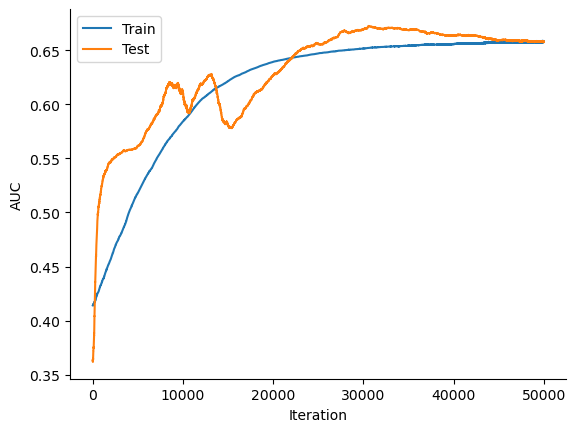

In [468]:
plt.plot(train_auc_history, label="Train")
plt.plot(test_auc_history, label="Test")
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.legend()
sns.despine()

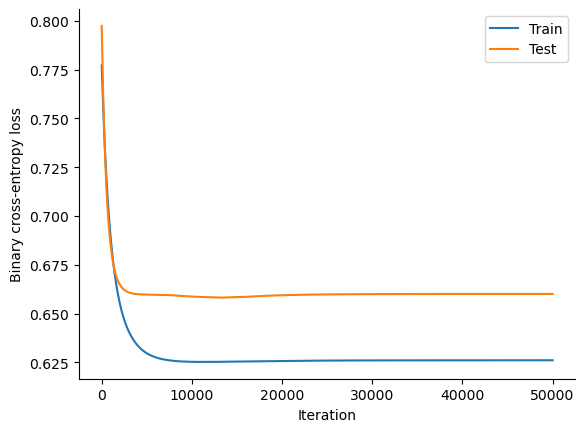

In [467]:
plt.plot(train_loss_history, label="Train")
plt.plot(test_loss_history, label="Test")
plt.xlabel("Iteration")
plt.ylabel("Binary cross-entropy loss")
plt.legend()
sns.despine()

## Avaliação de performance do modelo

A métrica AUC no modelo final considerando o conjunto de teste foi a seguinte:

In [469]:
test_scores = model(torch.from_numpy(test_features)).detach().numpy().flatten()
round(roc_auc_score(test_pheno.target_phenotype, test_scores), 4)

0.658

A distribuição dos scores de risco para cada grupo está exibida a seguir:

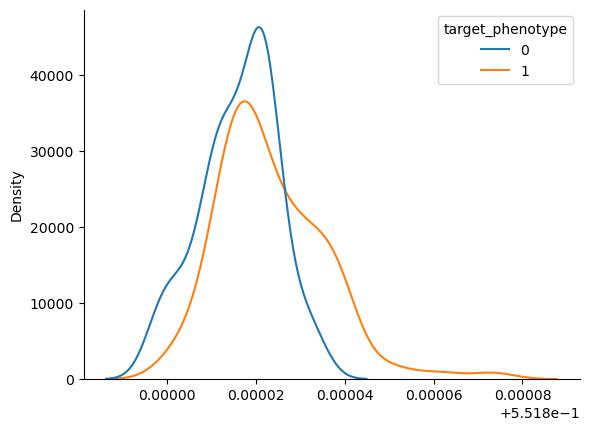

In [471]:
sns.kdeplot(x=test_scores, hue=test_pheno.target_phenotype.astype(int), common_norm=False)
sns.despine()

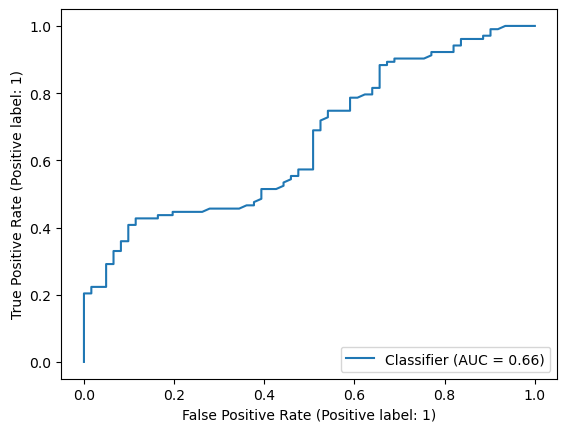

In [479]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(test_pheno.target_phenotype.astype(int), test_scores)

## Comparação dos pesos atualizados com os originais

Podemos comparar os pesos dos SNPs brutos do UKBB com as versões ajustadas pelo modelo de ML. Observa-se que os pesos não apresentaram modificações relevantes (permaneceram proporcionais aos pesos originais). Apesar disso, o score foi útil para classificar indivíduos com alto risco, que se posicionam na cauda direita da distribuição de risco.

In [474]:
new_weights = model.updated_weights.detach().numpy().flatten()
old_weights = model.base_weights.numpy()

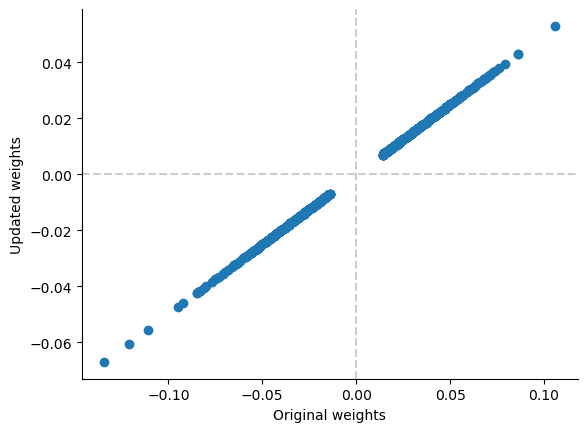

In [475]:
plt.scatter(old_weights, new_weights)
plt.axhline(0, c="k", alpha=0.2, ls="--")
plt.axvline(0, c="k", alpha=0.2, ls="--")
plt.xlabel("Original weights")
plt.ylabel("Updated weights")
sns.despine()

In [476]:
np.corrcoef(new_weights, old_weights)

array([[1., 1.],
       [1., 1.]])

O AUC obtido utilizando apenas o PRS sem refinamento foi o seguinte:

In [477]:
roc_auc_score(pheno.target_phenotype, old_weights @ allele_dosage)

0.5303385562287173

E o score com os pesos atualizados foi o seguinte:

In [478]:
roc_auc_score(pheno.target_phenotype, new_weights @ allele_dosage)

0.5303520537432465